# library import

In [1]:
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt

# data loading

In [2]:
print("starting loading data...")
#같은 디렉토리 내에 있는 csv파일을 탐색합니다.
filename_data = './satisfaction_data.csv'

#0~5번째 열은 feature로, 6번째 열은 class데이터로 저장합니다.
data_feature = np.loadtxt(filename_data, delimiter =',',usecols= (0,1,2,3,4,5), dtype=int)
data_class = np.loadtxt(filename_data, delimiter =',',usecols= (6), dtype='str')
number_data = data_feature.shape[0]

print("successfully loaded data.")
print("number of data = " + str(number_data))
print("")

starting loading data...
successfully loaded data.
number of data = 20000



# data inspection

In [3]:
#추후 normalization을 위한 minmax를 저장합니다.
#그리고 데이터의 전체적인 분포를 가늠하기위해
#각 열마다, 즉, 각 파라미터마다 최소, 최대, 평균, 분산을 출력합니다.

print("data inspection")
minmax = np.empty((6,2), float)

for i in range(6):
    print("data_col_"+str(i))
    minmax[i][0] = np.min(data_feature, axis=0)[i]
    print("min:"+str(minmax[i][0]))
    minmax[i][1] = np.max(data_feature, axis=0)[i]
    print("max:"+str(minmax[i][1]))
    print("mean:"+str(np.mean(data_feature, axis=0)[i]))
    print("var:"+str(np.var(data_feature, axis=0)[i]))
    print("")


data inspection
data_col_0
min:1.0
max:99.0
mean:43.22015
var:140.24748397747882

data_col_1
min:0.0
max:5.0
mean:2.3586
var:1.2923060399996893

data_col_2
min:0.0
max:2.0
mean:1.1708
var:0.31852736000004944

data_col_3
min:13769.0
max:1097453.0
mean:184706.98085
var:10226020824.74352

data_col_4
min:17.0
max:90.0
mean:39.4344
var:165.8094966400004

data_col_5
min:1.0
max:16.0
mean:10.30435
var:6.026421077499933



# Normalization

In [4]:
# 거리를 구할 때 유클리드 거리 (l2 norm)으로 구합니다.
# 한 요소의 범위가 너무 크다면, 그 feature때문에 다른 값들이 trivial 해집니다.
# 데이터의 분포 모두 최소가 0, 최대가 1이 되도록 normalization을 해줍니다.
print("starting normalization...")
normalized = np.empty((20000,6))
#print(normalized.shape[1])
for i in range(normalized.shape[1]):
    normalized[:, i] = (data_feature[:, i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

print(normalized)
print("data is normalized.")
print("")

starting normalization...
[[0.39795918 0.4        0.5        0.06745786 0.10958904 0.53333333]
 [0.39795918 0.4        0.5        0.22659188 0.50684932 0.6       ]
 [0.39795918 0.4        0.5        0.22427571 0.35616438 0.86666667]
 ...
 [0.39795918 0.4        0.5        0.15553796 0.20547945 0.26666667]
 [0.39795918 0.6        0.5        0.03829806 0.4109589  0.6       ]
 [0.5        0.8        0.5        0.04785066 0.24657534 0.8       ]]
data is normalized.



# augment feature and class data

In [5]:
#데이터를 섞을 때 feature와 class가 함께 이동하도록 데이터를 합쳐줍니다.
data_augmented = np.concatenate((normalized, data_class.reshape(20000, 1)), axis = 1)

#추후 계산의 편의를 위해 unsatisfied 는 0으로, satisfied는 1로 바꿉니다.
np.putmask(data_augmented, data_augmented == 'satisfied', 1)
np.putmask(data_augmented, data_augmented == 'unsatisfied', 0)


# KNN
## train data set, test data set separation

In [6]:
#데이터의 총 개수는 20000개로, 1:9로 나누면 2000, 18000입니다.
#훈련데이터에 사용할 데이터를 18000, 테스트에 사용할 데이터를 2000개로 설정합니다.
#0~19999의 숫자 중에서 2000개를 샘플링한다.

print("starting sampling data...")

sample_train_x = np.empty((10, 18000, 6))
sample_train_y = np.empty((10, 18000, 1))
sample_test_x = np.empty((10, 2000, 6))
sample_test_y = np.empty((10, 2000, 1))

for i in range(10):
    data_augmented_mixed = np.random.permutation(data_augmented).reshape(1, 20000, 7)
    sample_train_x[i], sample_test_x[i] = data_augmented_mixed[0, 2000:, :6], data_augmented_mixed[0, :2000, :6]
    sample_train_y[i], sample_test_y[i] = data_augmented_mixed[0, 2000:, 6].reshape(1, 18000, 1), data_augmented_mixed[0, :2000, 6].reshape(1, 2000, 1)
print("sample_train_x : " +str(sample_train_x.shape))
print("sample_train_y : " +str(sample_train_y.shape))
print("sample_test_x : " +str(sample_test_x.shape))
print("sample_test_y : " +str(sample_test_y.shape))
print("successfully sampled data.")
print("")

starting sampling data...
sample_train_x : (10, 18000, 6)
sample_train_y : (10, 18000, 1)
sample_test_x : (10, 2000, 6)
sample_test_y : (10, 2000, 1)
successfully sampled data.



## compute distance > matrix

In [7]:
#euclid_dist_matrix에는, 
#샘플마다 각 test_x에 대해서 모든 train_x에 대한 거리를 저장한다.

print("starting calculating distance by matrix...") 
number_train = sample_train_x.shape[1]
number_test = sample_test_x.shape[1]
euclid_dists_matrix = np.zeros((10, number_test, number_train))
for i in range(10):
    test_matrix = np.sum(np.square(sample_test_x[i]), axis=1).reshape(number_test, 1)
    train_matrix = np.sum(np.square(sample_train_x[i]), axis=1).reshape(1, number_train)
    euclid_dists_matrix[i] = np.sqrt(test_matrix + train_matrix -2*np.dot(sample_test_x[i], sample_train_x[i].T))
print(euclid_dists_matrix.shape)
print("successfully done.")
print("")

starting calculating distance by matrix...
(10, 2000, 18000)
successfully done.



## compute prediction

In [8]:
# k 로 지정한 수를 리스트로 저장해주면, 각 k에 대해서 연산합니다.
# 앞서서 최적의 k 에 대해서 논의했으므로, 지금은 하나의 k에 대해서만 계산합니다.
print("starting prediction for 10 data sets...")
k = [5]
prediction = np.empty((len(k), 10, number_test))

iteration = 0
for k_num in k:
    for i in range(10):
        for j in range(number_test):
            neareast_class = []
            
            #argsort는 넘파이 행렬을 인풋으로 받습니다.
            #받은 행렬을 오름차순으로 정렬하여,
            #정렬된 요소들의 인덱스를 반환합니다..

            #즉, np.argsort(euclid_dists_matrix[i][j]) 부분은
            #i번째 샘플의 j번째 테스트케이스에 대해서 모든 값들을 정렬하고,
            #정렬된 요소들의 정렬되기 전 인덱스를 반환합니다.
            #즉, j번째 test_x와 가장 가까운 순서부터 먼 순서까지 (오름차순으로 정렬했으므로) 
            #train_x의 인덱스를 반환합니다.
            #여기서 k번째까지를 가져와 nearest class에 저장합니다.
            neareast_class = sample_train_y[i][np.argsort(euclid_dists_matrix[i][j])][:k_num]

            #저장 형식을 갖게 지정한다.
            neareast_class = neareast_class.astype(int)

            #bincount란 non negative integer로 구성된 넘파이 배열에서
            #각각의 빈도수를 세는데 사용하는 메소드입니다.
            #0부터 가장 큰 값까지 각각의 발생 빈도수를 체크합니다.
            #정답 클래스는 0(unsatisfied), 1(satisfied) 이므로
            #[n m] (n, m은 0 이상의 정수)를 반환합니다.
            #n은 0인 값들의 개수, m은 1인 값들의 개수입니다.

            #argmax는 인풋으로 받은 행렬 중에서
            #가장 값이 큰 인덱스를 반환합니다.
            #즉, n이 m보다 크다면 n의 인덱스, 0을 반환합니다.
            #이 인덱스는 결국 클래스를 나타내게 됩니다.
            prediction[iteration][i][j] = np.argmax(np.bincount(neareast_class.reshape(k_num, )))
    iteration = iteration + 1
print("prediction : " +str(prediction.shape))
print("successfully done.")


starting prediction for 10 data sets...
prediction : (1, 10, 2000)
successfully done.


# compare prediction and real class

In [9]:
# 지정한 k 값들에 대해서 추정 값이 맞는지 확인합니다.

print("prediction result for each sample.")
for k_iter in range(len(k)):
    print("k: " + str(k[k_iter]))
    isAnswer = np.empty((10, 2000))
    #isAnswer에는 정답 - 추정한 클래스 값이 들어가 있습니다. 
    #즉, 요소가 0일 경우 해당 인덱스는 정답이고, 
    #그 이외의 경우 오답입니다.
    isAnswer = sample_test_y - prediction[k_iter].reshape(10, number_test, 1)

    for i in range(10):
        print("sample: " + str(i+1) +"  accuracy: "+str((np.count_nonzero(isAnswer[i] == 0)/number_test)*100))
    
    print("")

prediction result for each sample.
k: 5
sample: 1  accuracy: 76.14999999999999
sample: 2  accuracy: 75.75
sample: 3  accuracy: 76.64999999999999
sample: 4  accuracy: 76.25
sample: 5  accuracy: 74.55000000000001
sample: 6  accuracy: 74.05000000000001
sample: 7  accuracy: 75.75
sample: 8  accuracy: 74.75
sample: 9  accuracy: 75.4
sample: 10  accuracy: 75.55



# compute by hamming distance

In [10]:
#해밍 거리란 두 벡터간의 공통된 값의 수입니다.
#비트간 해밍거리는 같아지기 위해서 바꿔야하는 비트의 값이 해밍거리가 됩니다.
#즉, 해밍거리의 값이 커질 수록 유사도가 낮다고 할 수 있습니다. 
#해밍거리가 작다 = 유사도가 높다 = 가깝다.
#비트간 해밍거리를 구하기위해서는 XOR연산을 한 후, 1의 개수를 count 합니다.
#여기선 normalization이 필요없기 때문에 그대로 raw값을 사용합니다.

data_raw_augmented = np.concatenate((data_feature, data_class.reshape(20000, 1)), axis = 1)
np.putmask(data_raw_augmented, data_raw_augmented == 'satisfied', 1)
np.putmask(data_raw_augmented, data_raw_augmented == 'unsatisfied', 0)
#print(data_raw_augmented)

sample_raw_train_x = np.empty((10, 18000, 6))
sample_raw_train_y = np.empty((10, 18000, 1))
sample_raw_test_x = np.empty((10, 2000, 6))
sample_raw_test_y = np.empty((10, 2000, 1))

for i in range(10):
    data_raw_augmented_mixed = np.random.permutation(data_raw_augmented).reshape(1, 20000, 7)
    sample_raw_train_x[i], sample_raw_test_x[i] = data_raw_augmented_mixed[0, 2000:, :6], data_raw_augmented_mixed[0, :2000, :6]
    sample_raw_train_y[i], sample_raw_test_y[i] = data_raw_augmented_mixed[0, 2000:, 6].reshape(1, 18000, 1), data_raw_augmented_mixed[0, :2000, 6].reshape(1, 2000, 1)

#메모리 초과방지를 위해 타입 지정
subtracted_matrix = np.zeros((10, number_test, number_train, 6), int)
subtracted_logical_xor = np.zeros((10, number_test, number_train, 6), bool)
hamming_dists_matrix = np.zeros((10, number_test, number_train))

#해밍 거리로 변환
for i in range(10):
    subtracted_matrix[i] = sample_raw_test_x[i].reshape(number_test, 1, 6) - sample_raw_train_x[i].reshape(1, number_train, 6)
    subtracted_logical_xor[i] = np.logical_xor(subtracted_matrix[i], 0)
    sameistrue = np.logical_not(subtracted_logical_xor[i])
    hamming_dists_matrix[i] = sameistrue.sum(axis=2)
print(hamming_dists_matrix.shape)

(10, 2000, 18000)


In [11]:
k = [11, 13, 15, 17, 19, 21]
prediction_hamming = np.empty((len(k), 10, number_test))

iteration = 0
for k_num in k:
    for i in range(10):
        for j in range(number_test):
            neareast_class = []
            neareast_class = sample_raw_train_y[i][np.argsort(hamming_dists_matrix[i][j])][:k_num]
            neareast_class = neareast_class.astype(int)
            prediction_hamming[iteration][i][j] = np.argmax(np.bincount(neareast_class.reshape(k_num, )))
    iteration = iteration + 1

for k_iter in range(len(k)):
    isAnswer_hamming = np.empty((10, 2000))
    isAnswer_hamming = sample_raw_test_y - prediction_hamming[k_iter].reshape(10, number_test, 1)

    for i in range(10):
        print("k: " + str(k[k_iter])+ "  accuracy: "+str((np.count_nonzero(isAnswer_hamming[i] == 0)/number_test)*100))
    
    print("\n")

k: 11  accuracy: 53.400000000000006
k: 11  accuracy: 53.949999999999996
k: 11  accuracy: 51.0
k: 11  accuracy: 51.05
k: 11  accuracy: 52.349999999999994
k: 11  accuracy: 53.5
k: 11  accuracy: 55.65
k: 11  accuracy: 54.0
k: 11  accuracy: 54.900000000000006
k: 11  accuracy: 55.85


k: 13  accuracy: 53.400000000000006
k: 13  accuracy: 53.5
k: 13  accuracy: 52.5
k: 13  accuracy: 51.449999999999996
k: 13  accuracy: 52.7
k: 13  accuracy: 53.300000000000004
k: 13  accuracy: 56.65
k: 13  accuracy: 54.800000000000004
k: 13  accuracy: 56.25
k: 13  accuracy: 55.800000000000004


k: 15  accuracy: 53.349999999999994
k: 15  accuracy: 55.25
k: 15  accuracy: 53.15
k: 15  accuracy: 51.300000000000004
k: 15  accuracy: 52.349999999999994
k: 15  accuracy: 52.900000000000006
k: 15  accuracy: 57.25
k: 15  accuracy: 55.1
k: 15  accuracy: 55.2
k: 15  accuracy: 56.3


k: 17  accuracy: 53.800000000000004
k: 17  accuracy: 54.449999999999996
k: 17  accuracy: 53.15
k: 17  accuracy: 51.5
k: 17  accuracy: 52.9000000

# sklearn 으로 검증하기

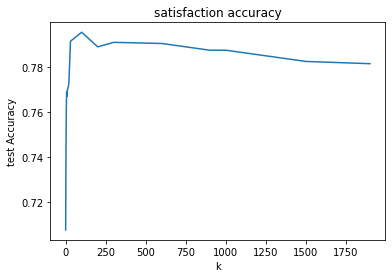

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

sk_data_feature = normalized
sk_data_class = data_class
np.putmask(sk_data_class, sk_data_class == 'satisfied', 1)
np.putmask(sk_data_class, sk_data_class == 'unsatisfied', 0)

sk_train_x, sk_test_x , sk_train_y, sk_test_y = train_test_split(sk_data_feature, sk_data_class, test_size = 0.1, random_state = 100)

classifier = KNeighborsClassifier(n_neighbors = 5)
classifier.fit(sk_train_x, sk_train_y)
k_list = [1, 3, 5, 7, 9, 11, 21, 31, 101, 201, 301, 601, 901, 1001, 1501, 1901]
#이렇게 돌리는데 11초
accuracies = []
for k in k_list:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(sk_train_x, sk_train_y)
  accuracies.append(classifier.score(sk_test_x, sk_test_y))
plt.plot(k_list, accuracies)
plt.xlabel("k")
plt.ylabel("test Accuracy")
plt.title("satisfaction accuracy")
plt.show()

# save to csv

In [13]:
#저장된 결과를 csv파일로 저장합니다.
#3차원으로 저장이 되어있기 때문에 2차원으로 변환해줍니다.
#이때, 정답의 값과 추정값을 붙여서 출력합니다.

print("starting saving process..")
result_class_prediction = np.empty((number_test, 0), int)
for i in range(10):
    concatenated = np.concatenate((sample_test_y[i], prediction[0][i].reshape(number_test, 1)), axis = 1)
    result_class_prediction = np.concatenate((result_class_prediction, concatenated), axis = 1)
print("successfullt concatenated results...")

np.savetxt("20173709.csv", result_class_prediction, fmt='%d', delimiter=',')
print("results saved to 20173709.csv")
print("successfully done.")

starting saving process..
successfullt concatenated results...
results saved to 20173709.csv
successfully done.
